# Preprocessing

## download data

In [1]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset, DatasetConfig
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset(DatasetConfig(
    use_raw=True
))

result_data = dataset.get(result_data)


In [2]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

net_official_development_assistance_received_current_usd
net_trade_in_goods_and_services_current_usd
fdi_net_inflows_current_usd
life_expectancy_at_birth_total_years
total_population
economic_activity
gini_income_inequality
poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population
population_size
gdp_per_person_employed_constant_2011_ppp_usd
individuals_using_the_internet_percent_of_population
research_and_development_expenditure_percent_of_gdp
manufacturing_value_added_percent_of_gdp
services_value_added_percent_of_gdp
unemployment_rate_percent_of_total_labor_force
consumer_price_index_change
gdp_current_usd
area
hydro_electric_energy_production
gas_energy_production
energy_use_kg_of_oil_equivalent_per_capita
coal_energy_production
petroleum_energy_production
renewables_excluding_hydro_share
education_expenditures
education_years


In [3]:
from src.clean.health_check import health_check_datadict, print_health_anomalies

report = health_check_datadict(datadict)
print_health_anomalies(report)



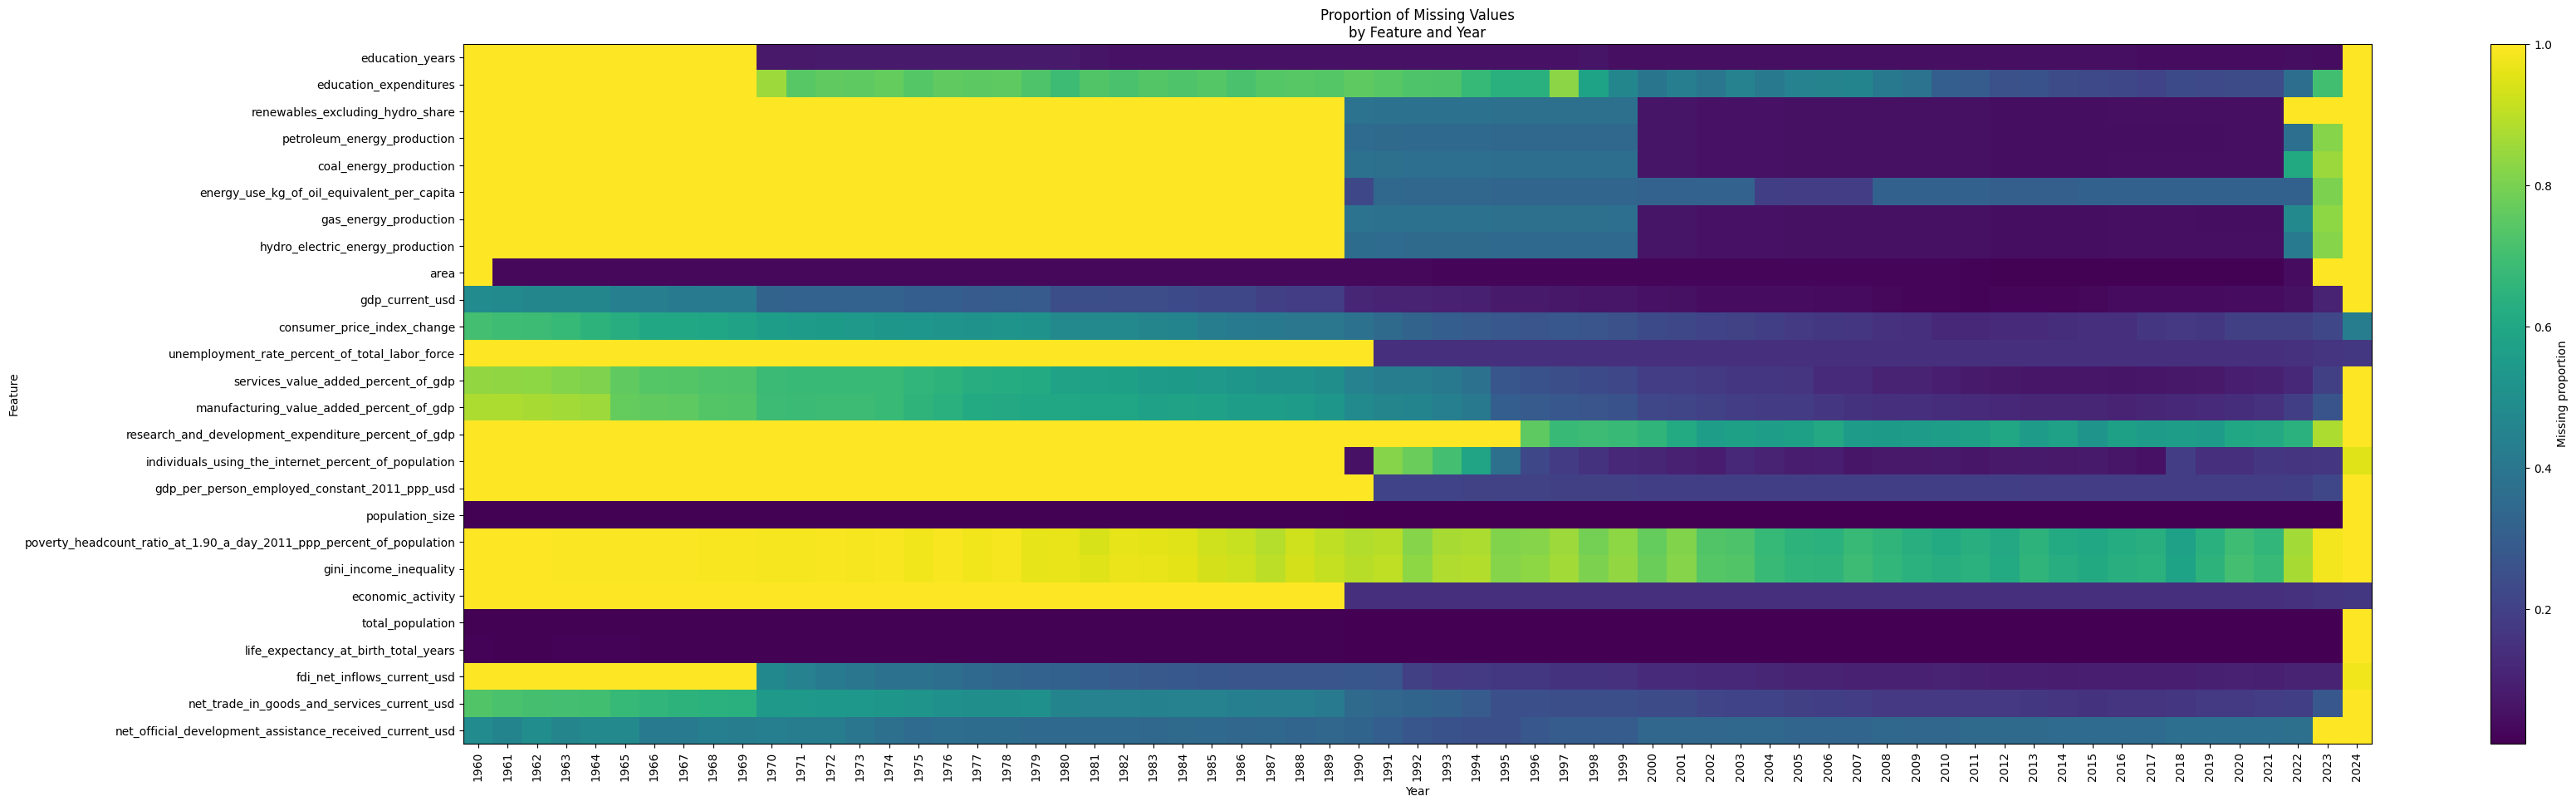

In [4]:
from src.clean.missing import compute_feature_yearly_missing, plot_feature_missing_heatmap

hm = compute_feature_yearly_missing(datadict)

plot_feature_missing_heatmap(hm)


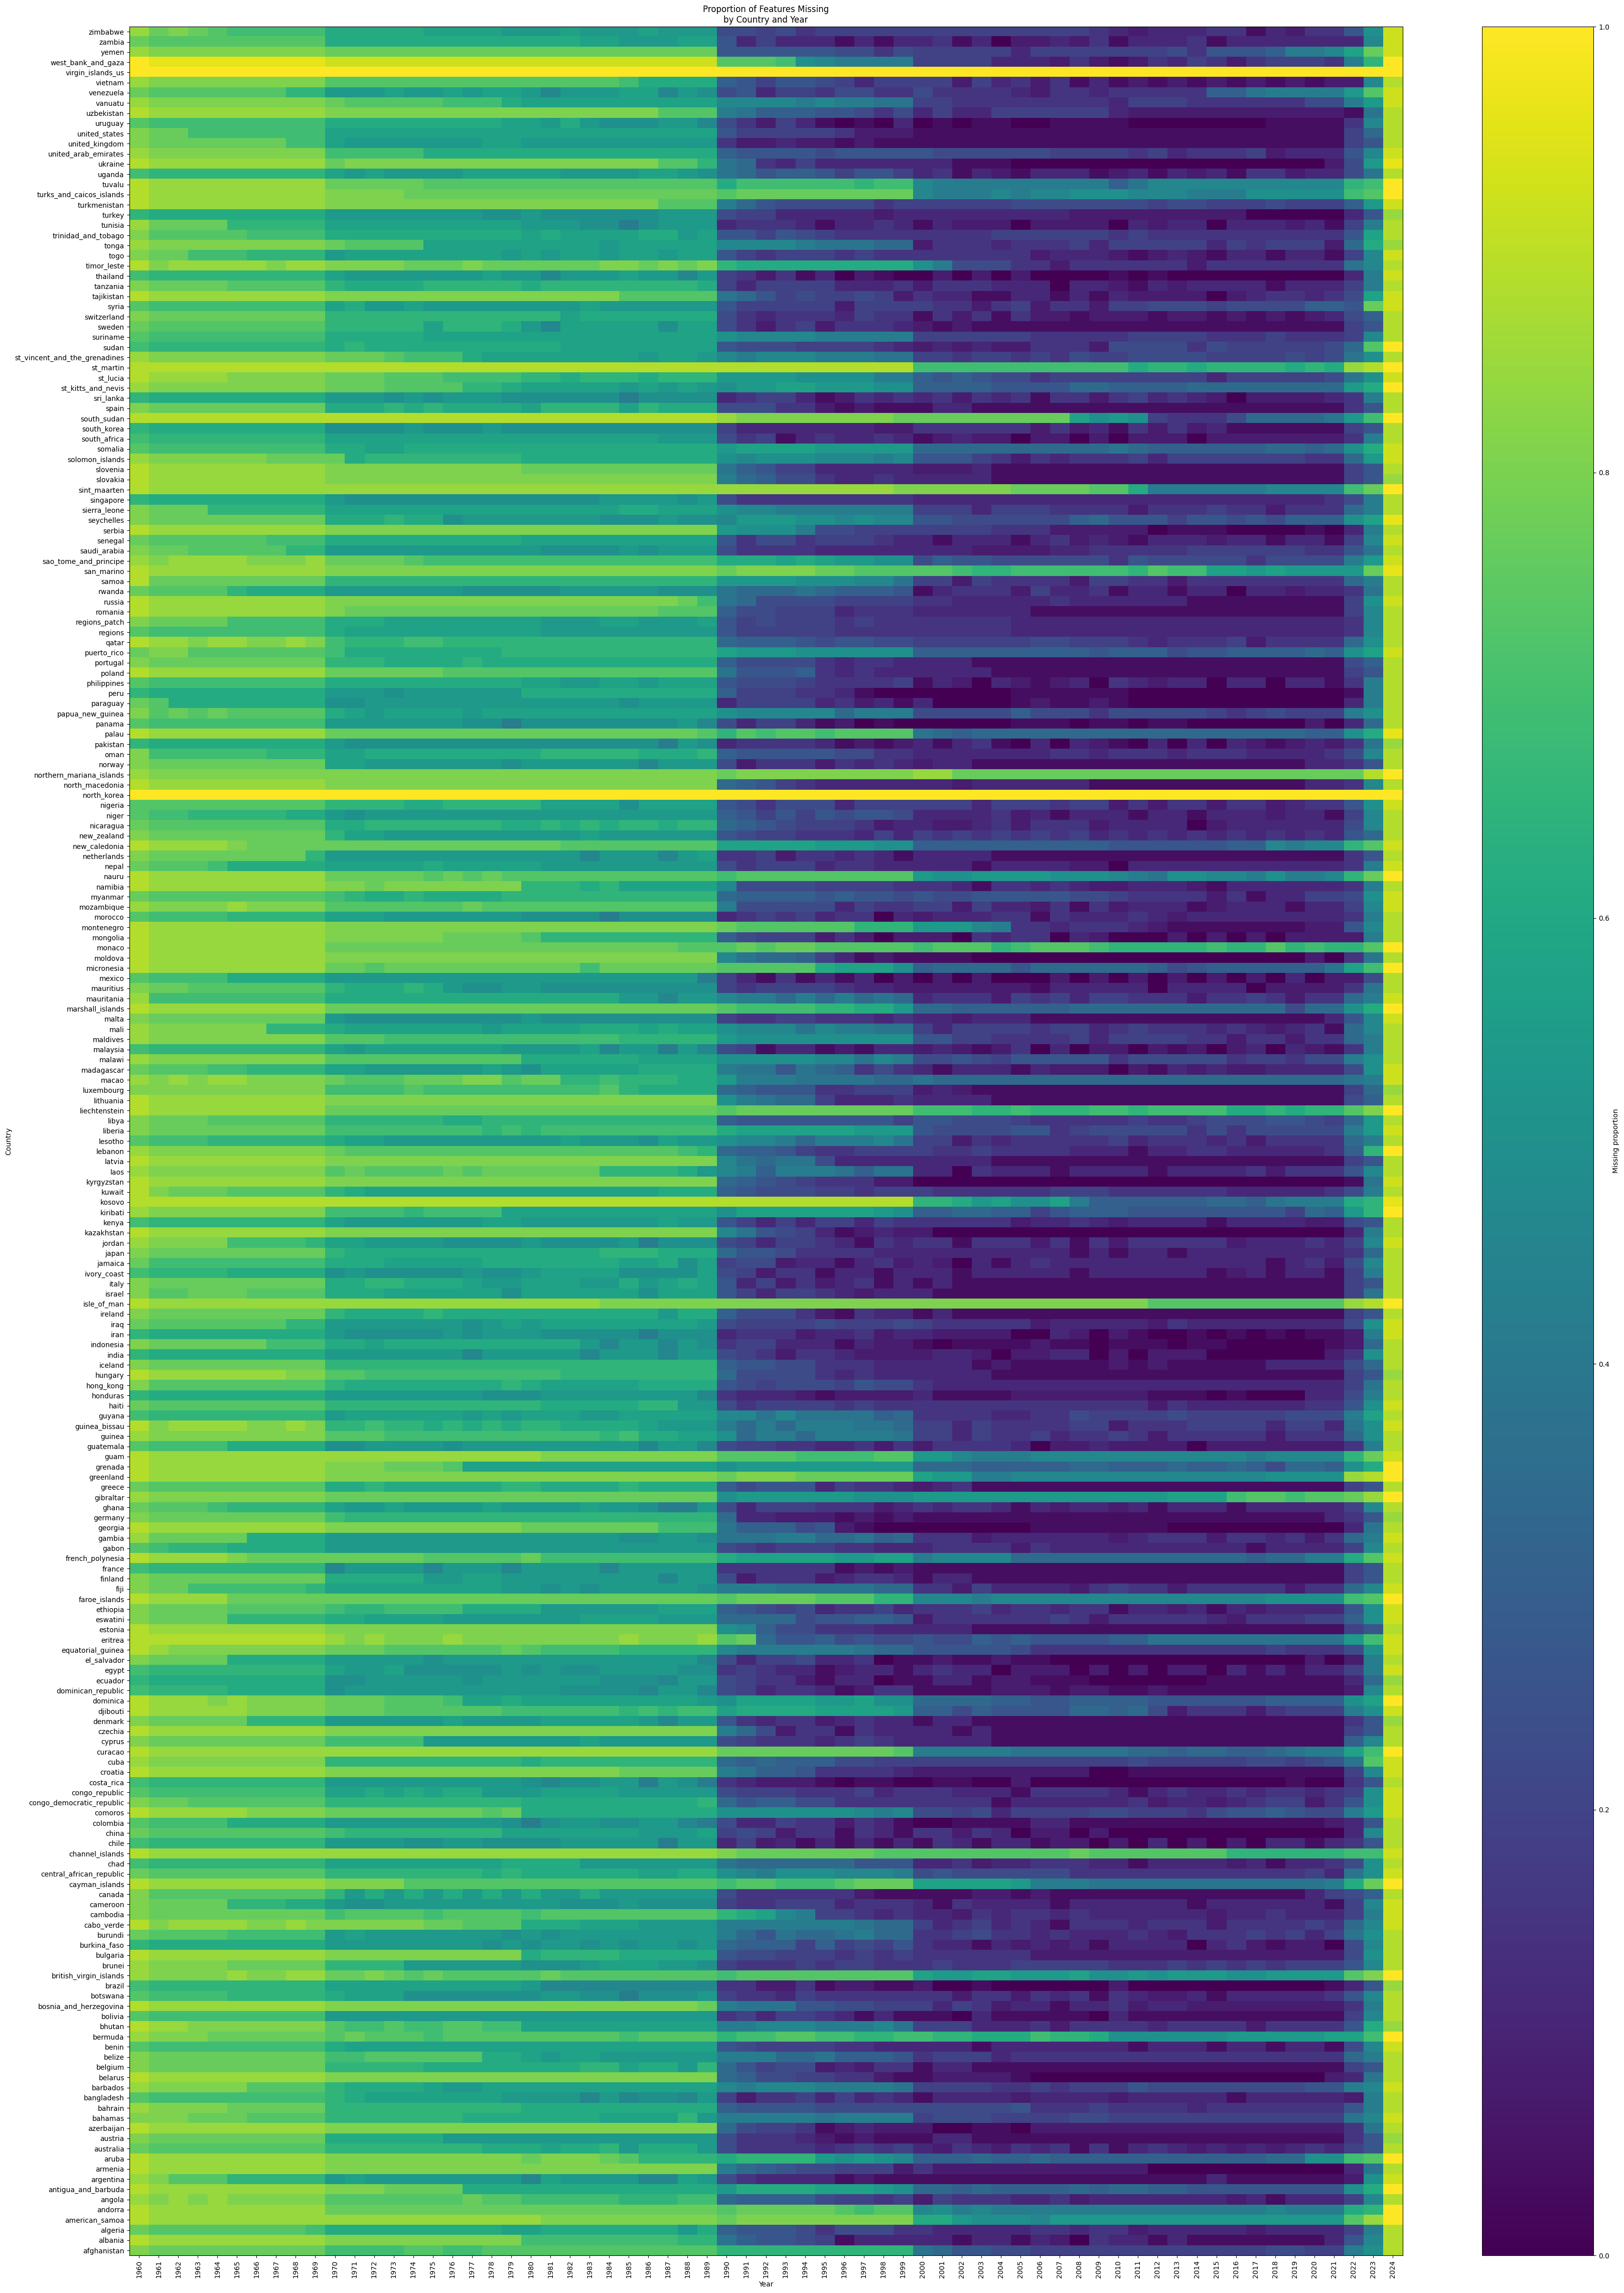

In [5]:

from src.clean.missing import compute_country_yearly_missing, plot_country_missing_heatmap


cty_hm = compute_country_yearly_missing(datadict)
plot_country_missing_heatmap(cty_hm)


In [6]:
ml = result_data.ml_ready

features = [c for c in ml.columns if c not in ("date", "country")]

na_per_feature = ml[features].isna().sum().sort_values(ascending=False)
print("Missing values per feature (all countries):")
print(na_per_feature.to_markdown(), "\n")

na_per_country = (
    ml
    .groupby("country")[features]
    .apply(lambda df: df.isna().sum().sum())
    .sort_values(ascending=False)
)
print("Missing values per country (all features):")
print(na_per_country.to_markdown())


Missing values per feature (all countries):
|                                                                      |     0 |
|:---------------------------------------------------------------------|------:|
| gini_income_inequality                                               | 12124 |
| poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population | 12040 |
| research_and_development_expenditure_percent_of_gdp                  | 11822 |
| energy_use_kg_of_oil_equivalent_per_capita                           |  9153 |
| education_expenditures                                               |  8959 |
| gdp_per_person_employed_constant_2011_ppp_usd                        |  8413 |
| renewables_excluding_hydro_share                                     |  8312 |
| individuals_using_the_internet_percent_of_population                 |  8199 |
| coal_energy_production                                               |  8174 |
| gas_energy_production                                          

In [7]:
filtered_dd = {
    name: df.loc[df.index.year > 1990]
    for name, df in datadict.items()
}

def drop_top_k_features_and_top_m_countries(
    data_dict: Dict[str, pd.DataFrame],
    k: int,
    m: int
) -> Dict[str, pd.DataFrame]:
    """
    From data_dict[name] = df (dates × countries), 
    1) drop the k indicator‐names with the largest overall NaN‐fraction,
    2) then drop the m country‐columns with the largest overall NaN‐fraction
       across the remaining DataFrames.
    """
    # 1) Compute NaN‐fraction per feature (averaged over all entries)
    nan_frac_feat = {
        name: df.isna().stack().mean()
        for name, df in data_dict.items()
    }
    # pick top-k worst
    drop_feats = sorted(nan_frac_feat, key=nan_frac_feat.get, reverse=True)[:k]
    filtered_feats = {
        name: df
        for name, df in data_dict.items()
        if name not in drop_feats
    }

    # 2) Compute NaN‐fraction per country across the remaining features
    #    (all DataFrames share the same full date‐index :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1})
    n_dates = next(iter(filtered_feats.values())).shape[0]
    n_feats = len(filtered_feats)
    # sum total NaNs for each country over all features
    country_nan_counts = {
        country: sum(df[country].isna().sum() for df in filtered_feats.values())
        for country in next(iter(filtered_feats.values())).columns
    }
    # total entries per country = n_dates * n_feats
    country_nan_frac = {
        c: cnt / (n_dates * n_feats)
        for c, cnt in country_nan_counts.items()
    }
    # pick top-m worst countries
    drop_countries = sorted(country_nan_frac, key=country_nan_frac.get, reverse=True)[:m]

    # 3) Drop those countries from every remaining DataFrame
    final_dict = {
        name: df.drop(columns=drop_countries)
        for name, df in filtered_feats.items()
    }

    return final_dict

cleaned_dd = drop_top_k_features_and_top_m_countries(filtered_dd, k=4, m=4)


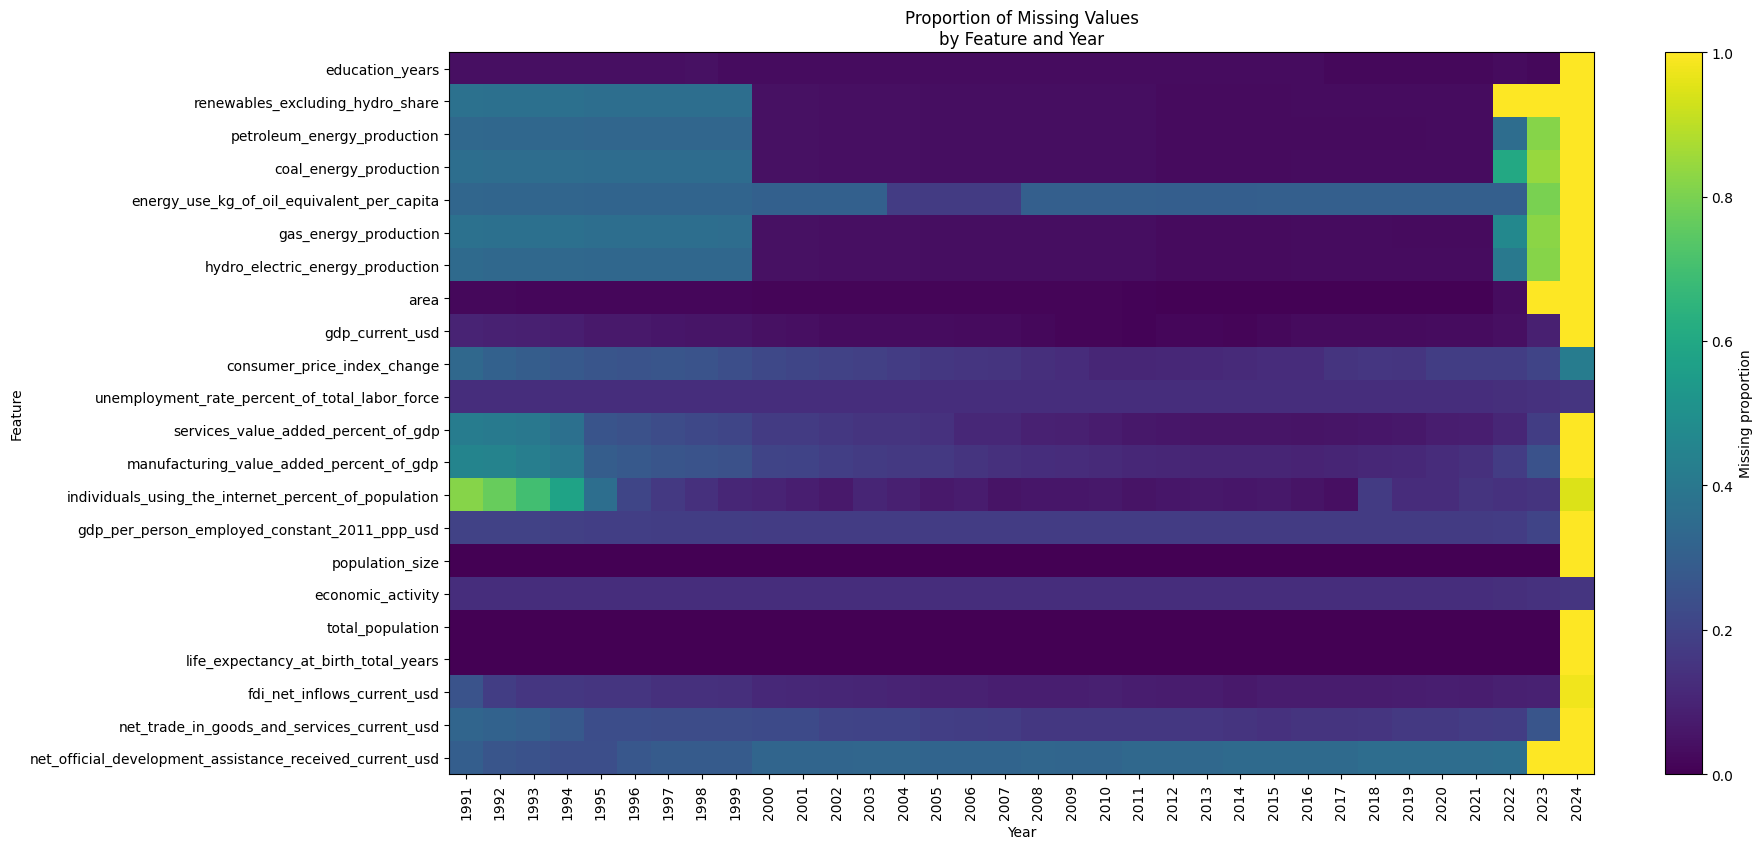

In [8]:
hm = compute_feature_yearly_missing(cleaned_dd)

plot_feature_missing_heatmap(hm)


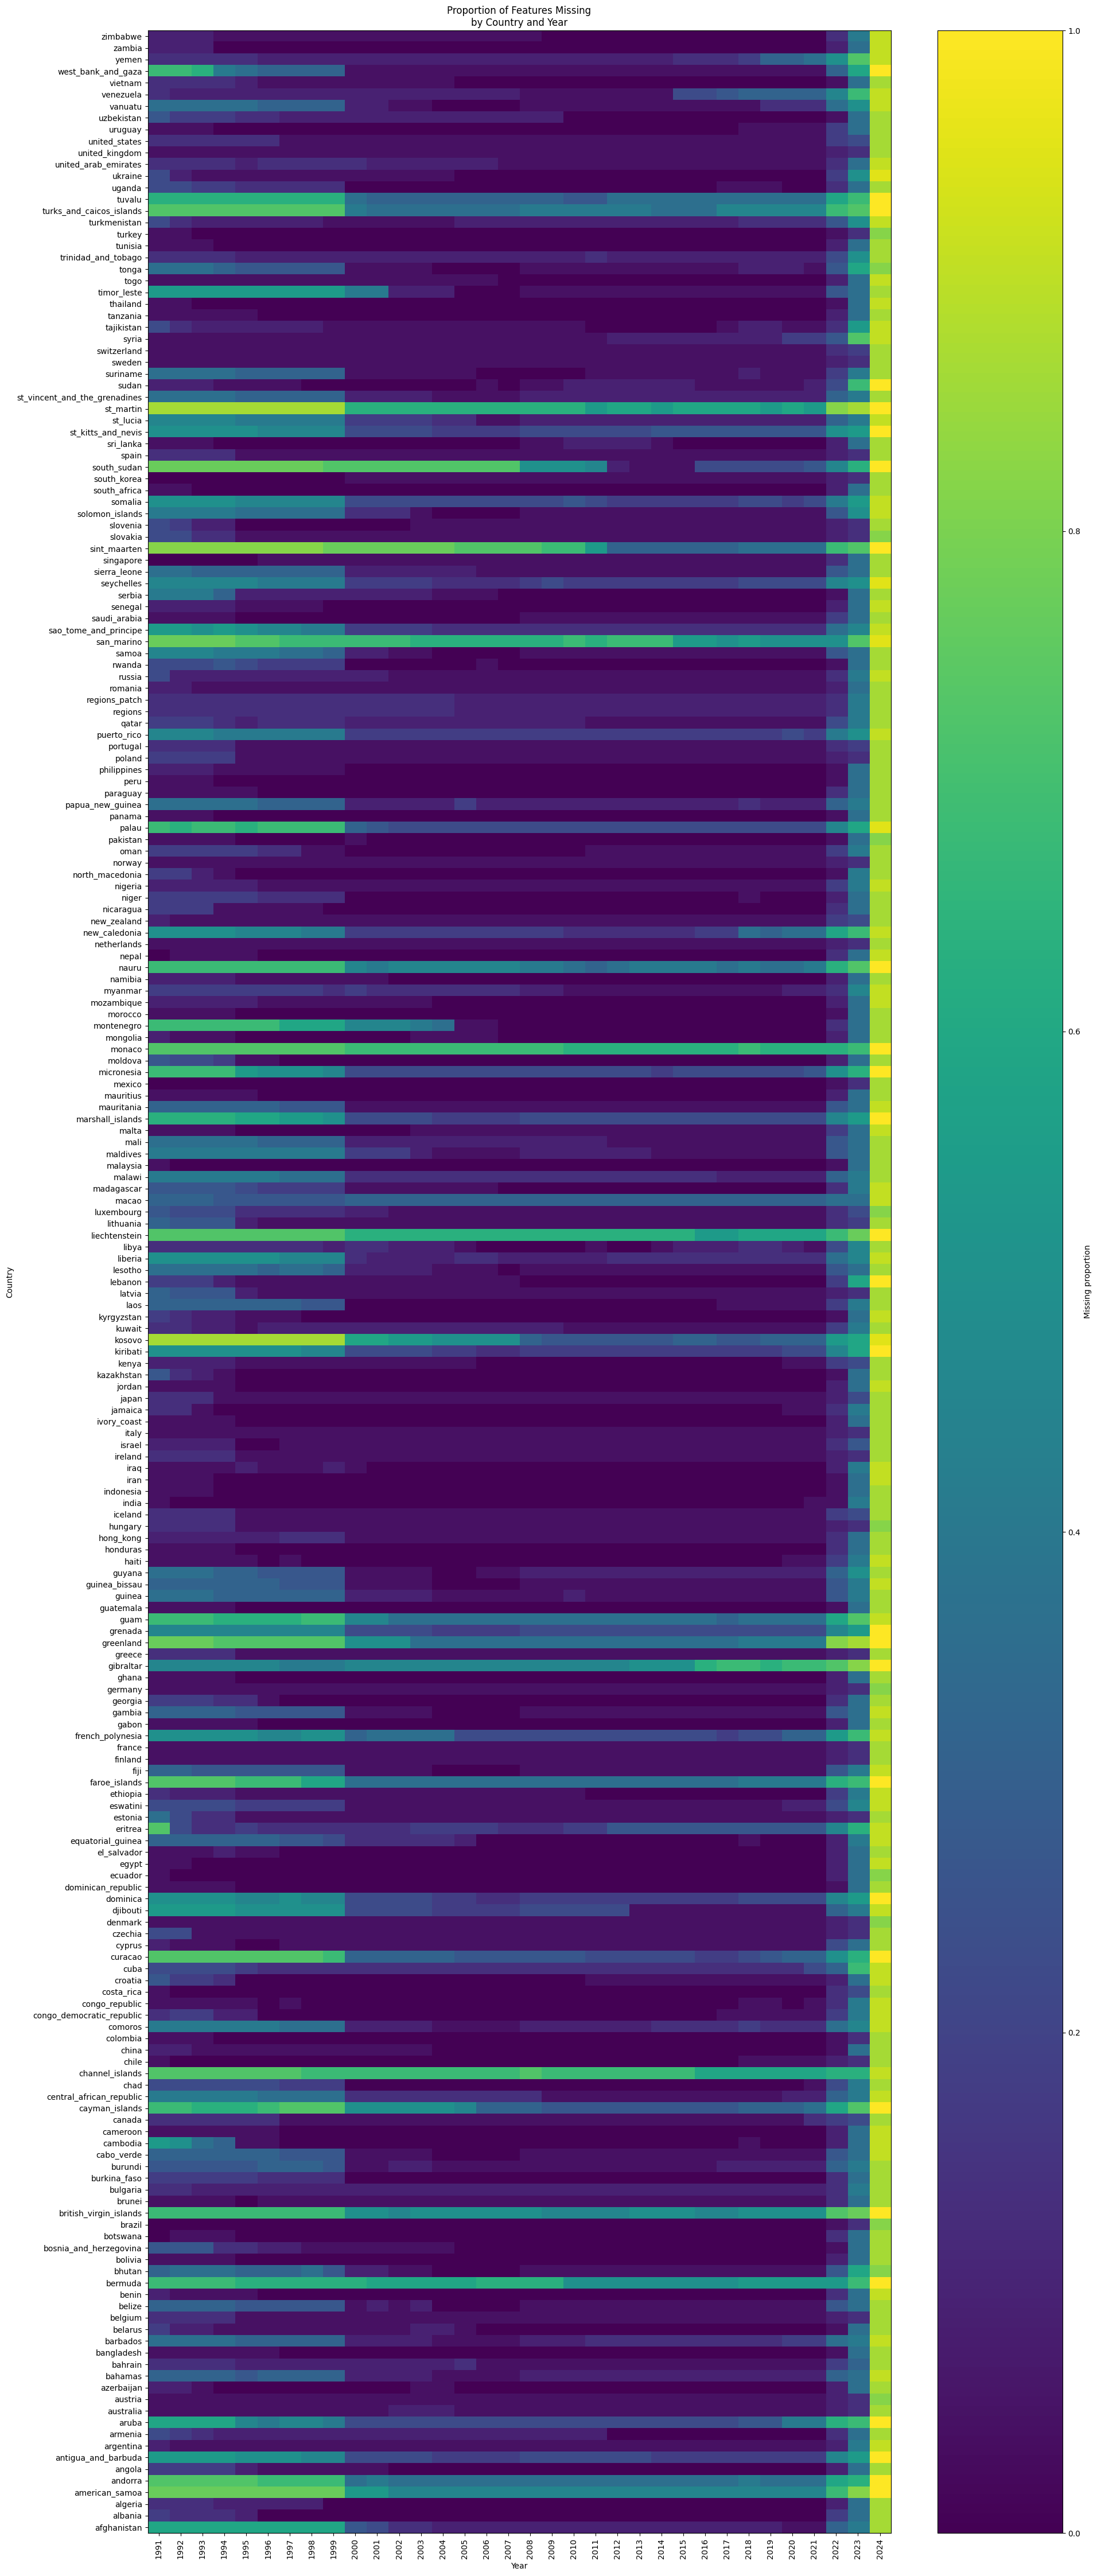

In [9]:
cty_hm = compute_country_yearly_missing(cleaned_dd)
plot_country_missing_heatmap(cty_hm)
